## Histogram-based Outlier Score (HBOS)

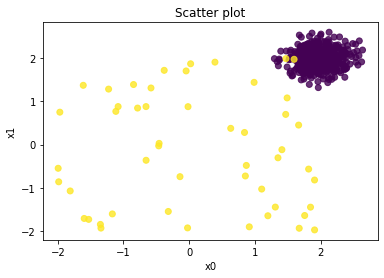

In [113]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyod.utils.data import generate_data
contamination = 0.1 # percentage of outliers
n_train = 500       # number of training points
n_test = 500        # number of testing points
n_features = 2      # number of features
X_train, X_test, y_train, y_test = generate_data(
    n_train=n_train, 
    n_test=n_test, 
    n_features= n_features, 
    contamination=contamination, 
    random_state=123)

# Make the 2d numpy array a pandas dataframe for each manipulation 
X_train_pd = pd.DataFrame(X_train)
    
# Plot
plt.scatter(X_train_pd[0], X_train_pd[1], c=y_train, alpha=0.8)
plt.title('Scatter plot')
plt.xlabel('x0')
plt.ylabel('x1')
plt.show()

In [90]:
from pyod.models.hbos import HBOS
n_bins = 50
hbos = HBOS(n_bins=n_bins)
hbos.fit(X_train)
HBOS(alpha=0.1, contamination=0.1, n_bins=n_bins, tol=0.5)
y_train_scores = hbos.decision_function(X_train)

In [91]:
y_test_pred = hbos.predict(X_test) # outlier labels (0 or 1)
# Because it is '0' and '1', we can run a count statistic. 
unique, counts = np.unique(y_test_pred, return_counts=True)
dict(zip(unique, counts))
# And you can generate the anomaly score using clf.decision_function:
y_test_scores = hbos.decision_function(X_test)

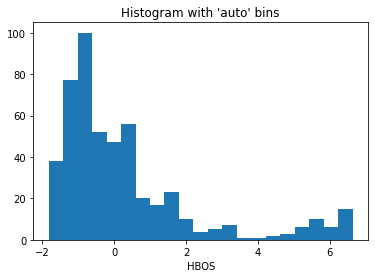

In [114]:
import matplotlib.pyplot as plt
plt.hist(y_test_scores, bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram with 'auto' bins")
plt.xlabel('HBOS')
plt.show()

In [110]:
threshold = 4
# Let's see how many '0's and '1's.
df_test = pd.DataFrame(X_test)
df_columns = df_test.columns
df_test['Anomaly_Score'] = y_test_scores
df_test['Group'] = np.where(df_test['Anomaly_Score']< threshold, 'Normal', 'Outlier')

# Now let's show the summary statistics:
cnt = df_test[['Group','Anomaly_Score']].groupby('Group').count().reset_index().rename(columns={'Anomaly_Score':'Count'})
cnt['Count %'] = (cnt['Count'] / cnt['Count'].sum()) * 100 # The count and count %
stat = df_test.groupby('Group').mean().reset_index() # The avg.
cnt.merge(stat, left_on='Group',right_on='Group') # Put the count and the avg. together

,Group,Count,Count %,0,1,Anomaly_Score
0,Normal,458,91.6,1.990106,1.970008,-0.215748
1,Outlier,42,8.4,-0.036965,-0.079419,5.836369


In [111]:
Actual_pred = pd.DataFrame({'Actual': y_test, 'Anomaly_Score': y_test_scores})
Actual_pred['Pred'] = np.where(Actual_pred['Anomaly_Score']< threshold,0,1)
pd.crosstab(Actual_pred['Actual'],Actual_pred['Pred'])

Pred,0,1
Actual,,
0.0,450,0
1.0,8,42
